In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from datetime import datetime
from statsmodels.tsa.api import VAR

In [112]:
## Preprocessing

# Load the data
govdat = pd.read_csv("data/government_spending/govdat3908.csv")

# Remove data before start_time
start_date = datetime(1947,1,1)
govdat = govdat[govdat["quarter"] >= start_date.year]
num_obs = len(govdat)

# Create quarter date index
govdat["qdate"] = pd.date_range(start=start_date, periods=num_obs, freq="QE")
govdat.set_index("qdate", inplace=True)

# Set dtypes
govdat.replace(".", np.nan, inplace=True)
govdat = govdat.astype(float)

# Create linear and quadratic trend
govdat["t"] = govdat["quarter"]
govdat["t2"] = govdat["quarter"]**2

# Create rwbus variable
govdat["rwbus"] = govdat["nwbus"] / govdat["pbus"]

# Create log variables for the variables in the list
varlist = [
    "rgdp",
    "rcons",
    "rcnd",
    "rcsv",
    "rcdur",
    "rcndsv",
    "rinv",
    "rinvfx",
    "rnri",
    "rres",
    "tothours",
    "tothoursces",
    "rgov",
    "rdef",
]

for var in varlist:
    govdat[f"l{var}"] = np.log(govdat[var] / govdat["totpop"])

# Log variables for other variables in the list
varlist2 = ["totpop", "rwbus", "cpi", "pgdp"]
for var in varlist2:
    govdat[f"l{var}"] = np.log(govdat[var])

## Build the VAR model using the standard identification method

# Select the columns for the model
vars_for_var = [
    "lrgov",
    "lrgdp",
    "lrcndsv",
    "lrinvfx",
    "ltothoursces",
    "lrwbus",
    "amtbr",
]

# Create the VAR model
model = VAR(govdat[vars_for_var], exog=govdat[["t", "t2"]])
lag_order = 4  # Lags from 1 to 4

# Fit the model
var_result = model.fit(lag_order, trend='n')

# Get the impulse response function (IRF)
irf = var_result.irf(20)

# Plot the IRF for government spending shock
# irf.plot(impulse="lrgov", signif = 0.68, orth = True)
# plt.show()

# Regression
target = "lrgdp"
regressor = "lrgov"
instruments = "lrgov"

# Param
horizons = range(12)
num_var = len(vars_for_var)
burn_in = 0
T = num_obs - lag_order - len(horizons) - burn_in - 1 

# Matrix
X = govdat[vars_for_var].to_numpy()
exog = govdat[["t", "t2"]].to_numpy()
X_stacked = np.hstack([X[burn_in + lag:burn_in + T+lag] for lag in range(lag_order)]).T

X_H = np.hstack([X[lag_order + burn_in + h + 1 : lag_order + T + burn_in + h + 1] for h in horizons]).T
y_H = np.vstack([X_H[h * num_var + vars_for_var.index(target)] for h in horizons])
Y_H = np.vstack([X_H[h * num_var + vars_for_var.index(regressor)] for h in horizons])

# Forecast Matrix
X_H_fcst = np.zeros(X_H.shape)
for t in range(T):
    X_t = X[: burn_in + t + lag_order]
    for h in horizons:
        fcst = var_result.forecast(
            y=X_t,
            exog_future=exog[burn_in + t + lag_order + 1 : burn_in + t + lag_order + 1 + h + 1],
            steps=h + 1,
        )[-1]
        X_H_fcst[h*num_var:(h+1)*num_var, t] = fcst

# Error Forecast Matrix
X_H_perp = X_H - X_H_fcst
y_H_perp = np.vstack([X_H_perp[h * num_var + vars_for_var.index(target)] for h in horizons])
Y_H_perp = np.vstack([X_H_perp[h * num_var + vars_for_var.index(regressor)] for h in horizons])

/Users/maximecoulet/miniconda3/envs/spiv_replic/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


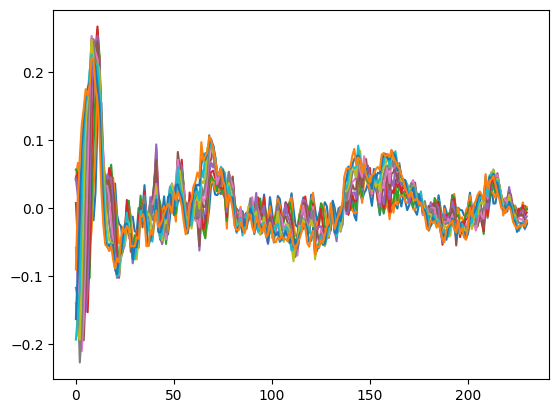

In [113]:
plt.plot(Y_H_perp.T)

In [68]:
X_H - X_H_fcst

array([[-0.09535724, -0.08629892, -0.11412967, ..., -0.00363891,
        -0.00233502, -0.00778674],
       [-0.06004341, -0.0621085 , -0.08103809, ...,  0.00207082,
        -0.00156136, -0.00086905],
       [-0.06083216, -0.07263739, -0.06560905, ...,  0.00308351,
         0.00224133,  0.00246993],
       ...,
       [-0.71452684, -0.70098826, -0.70246451, ..., -0.00698165,
        -0.01227001, -0.02501933],
       [-0.75365816, -0.7549345 , -0.74808392, ..., -0.05002709,
        -0.04885119, -0.04820271],
       [-0.13683271, -0.11854678, -0.11518892, ...,  0.01163567,
         0.01426248,  0.01513684]], shape=(84, 231))

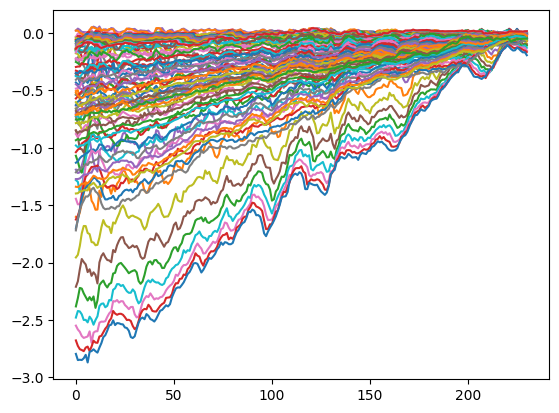

In [67]:
plt.plot((X_H-X_H_fcst).T)

In [63]:
X_H - X_H_fcst

array([[-0.09535724, -0.08629892, -0.11412967, ..., -0.00363891,
        -0.00233502, -0.00778674],
       [-0.06004341, -0.0621085 , -0.08103809, ...,  0.00207082,
        -0.00156136, -0.00086905],
       [-0.06083216, -0.07263739, -0.06560905, ...,  0.00308351,
         0.00224133,  0.00246993],
       ...,
       [-0.71452684, -0.70098826, -0.70246451, ..., -0.00698165,
        -0.01227001, -0.02501933],
       [-0.75365816, -0.7549345 , -0.74808392, ..., -0.05002709,
        -0.04885119, -0.04820271],
       [-0.13683271, -0.11854678, -0.11518892, ...,  0.01163567,
         0.01426248,  0.01513684]], shape=(84, 231))

In [27]:
govdat[vars_for_var].to_numpy()

array([[-9.02970559, -9.23305678, -9.16034015, ..., -7.07137405,
        -1.07579234,  0.238     ],
       [-9.0281414 , -9.23931444, -9.14961097, ..., -7.08189431,
        -1.06596109,  0.238     ],
       [-9.02338199, -9.24450763, -9.15232544, ..., -7.07845518,
        -1.08341268,  0.238     ],
       ...,
       [-7.96342234, -7.95997779, -7.96489578, ..., -7.05775294,
         0.31157939,  0.35299999],
       [-7.95402604, -7.96914404, -7.97349312, ..., -7.06764104,
         0.31195691,  0.35299999],
       [-7.95368053, -7.98550075, -7.97819656, ..., -7.08543964,
         0.32084492,  0.35299999]], shape=(248, 7))

In [ ]:
# Now for the Ramey-Shapiro method with military shock dates (assuming 'wara' is the military shock)
# Assuming you have a variable 'wara' indicating military shock periods

# Augment the VAR with the military shock dates variable
vars_for_var_ramey = [
    "wara",
    "lrgov",
    "lrgdp",
    "lrcndsv",
    "lrinvfx",
    "ltothoursces",
    "lrwbus",
    "amtbr",
]

# Create the VAR model for Ramey-Shapiro method
model_ramey = VAR(govdat[vars_for_var_ramey])
var_result_ramey = model_ramey.fit(lag_order)

# Get the impulse response function (IRF) for military shock
irf_ramey = var_result_ramey.irf(20)

# Plot the IRF for military shock
irf_ramey.plot(impulse="wara", signif=0.68)
plt.show()